Name: Dwi Fitria Astari Lubis

CUSTOMER CHURN PREDICTION

Develop a model to predict customer churn for a subscription based service or business. Use historical customer data, including features like usage behavior and customer demographics, and try algorithms like Logistic Regression, Random Forests, or Gradient Boosting to predict churn.

source of dataset: https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction
It is the dataset of a U.S. bank customer for getting the information that , this particular customer will leave bank or not.

In [14]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

In [7]:
#Load dataset and Profiling data
df=pd.read_csv('C:\\Users\\Dwi Fitria\\Intern\\CODSOFT\\CODSOFT\\3. Churn Modeling\\Churn_Modelling.csv')

In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
df=df.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1)

In [11]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [15]:
# Define numerical and categorical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender']

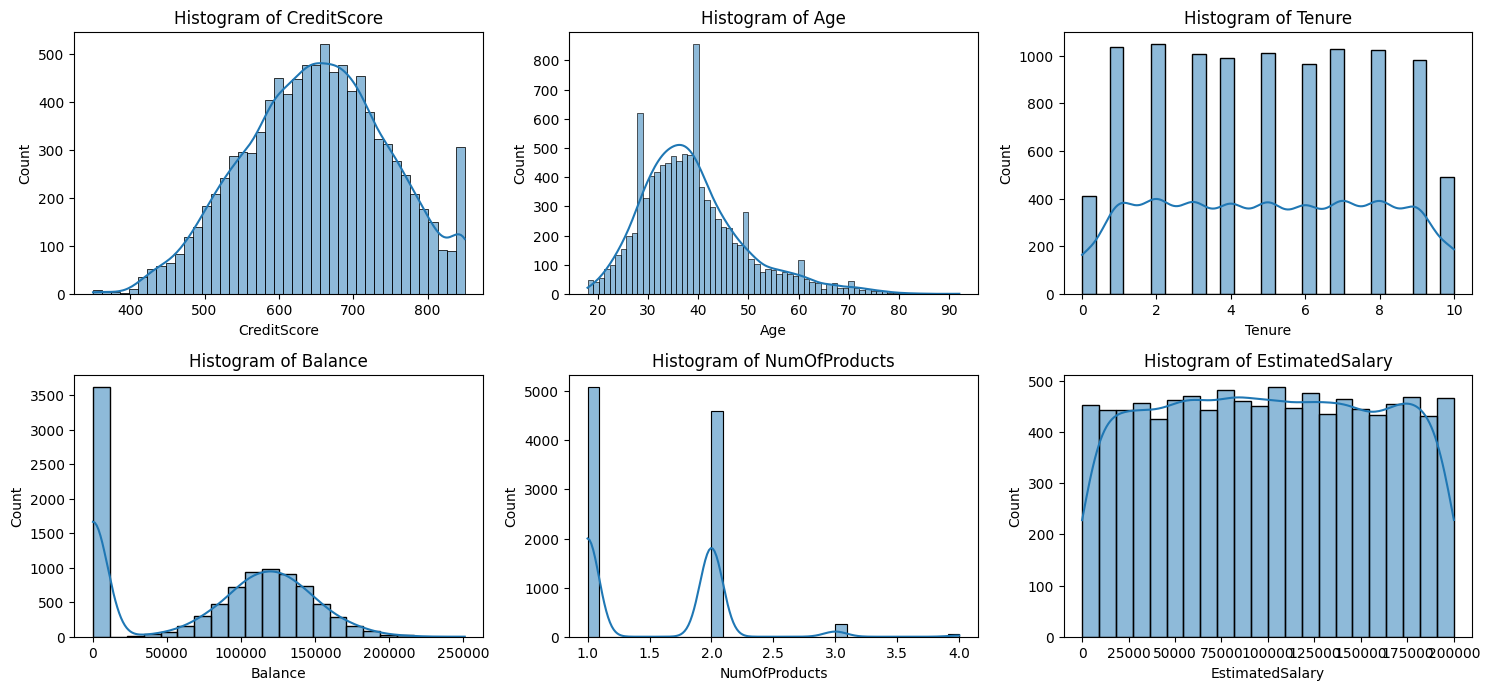

In [23]:
# Visual of numerical features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)  
    sns.histplot(df[feature], kde=True) 
    plt.title(f'Histogram of {feature}')
    plt.tight_layout() 
plt.show()


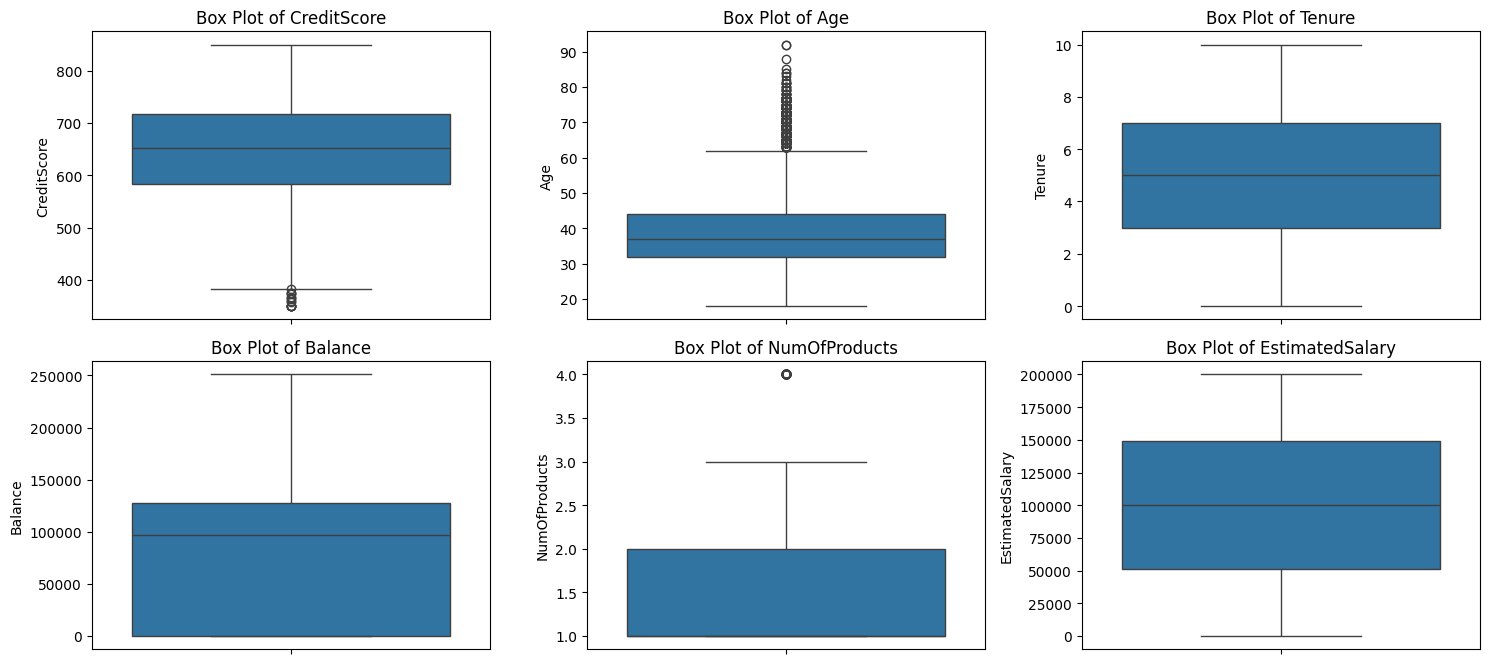

column: (0, 'CreditScore')
  Upper Whisker: 919.0
  Lower Whisker: 383.0
column: (1, 'Age')
  Upper Whisker: 62.0
  Lower Whisker: 14.0
column: (2, 'Tenure')
  Upper Whisker: 13.0
  Lower Whisker: -3.0
column: (3, 'Balance')
  Upper Whisker: 319110.60000000003
  Lower Whisker: -191466.36000000002
column: (4, 'NumOfProducts')
  Upper Whisker: 3.5
  Lower Whisker: -0.5
column: (5, 'EstimatedSalary')
  Upper Whisker: 296967.45375
  Lower Whisker: -96577.09624999999


In [24]:
# 2. Box Plots for Numerical Features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)  # Adjust subplot grid as needed
    sns.boxplot(y=df[feature]) # Boxplot on the y-axis
    plt.title(f'Box Plot of {feature}')
    plt.tight_layout()
plt.show()

for i, feature in enumerate(numerical_features):
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1
  upper_whisker = Q3 + 1.5 * IQR
  lower_whisker = Q1 - 1.5 * IQR

  print(f'column: {i,feature}')
  print(f'  Upper Whisker: {upper_whisker}')
  print(f'  Lower Whisker: {lower_whisker}')

1. CreditScore: Roughly bell-shaped, slightly right-skewed. The majority of customers have credit scores in a moderate range. The few low scores might indicate customers with financial difficulties, which could be related to churn.
2. Age: Approximates a normal distribution but wider.
3. Tenure: The whiskers (upper: 13.0, lower: -3.0) encompass almost the entire range, indicating that tenure is fairly evenly distributed. I want to analyze churn across different tenure segments.
4. Balance: the extreme skewness. Balance is likely a strong predictor of churn. The high skewness suggests that a transformation (log transformation) would be beneficial.
5. NumOfProducts: Discrete variable, most customers have 1 or 2 products.
6. EstimatedSalary: No significant outliers

In [25]:
# Apply log transformation to 'Balance'
df['LogBalance'] = np.log(df['Balance'] + 1)  # Add 1 to handle 0 values

# Update numerical_features to include 'LogBalance' and remove 'Balance'
numerical_features = ['CreditScore', 'Age', 'Tenure', 'LogBalance', 'NumOfProducts', 'EstimatedSalary']

In [34]:
# Get descriptive statistics
description = df[numerical_features].describe()

# Print the statistics
print(description)

        CreditScore           Age        Tenure    LogBalance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800      7.441327       1.530200   
std       96.653299     10.487806      2.892174      5.606400       0.581654   
min      350.000000     18.000000      0.000000      0.000000       1.000000   
25%      584.000000     32.000000      3.000000      0.000000       1.000000   
50%      652.000000     37.000000      5.000000     11.484521       1.000000   
75%      718.000000     44.000000      7.000000     11.757010       2.000000   
max      850.000000     92.000000     10.000000     12.432806       4.000000   

       EstimatedSalary  
count     10000.000000  
mean     100090.239881  
std       57510.492818  
min          11.580000  
25%       51002.110000  
50%      100193.915000  
75%      149388.247500  
max      199992.480000  


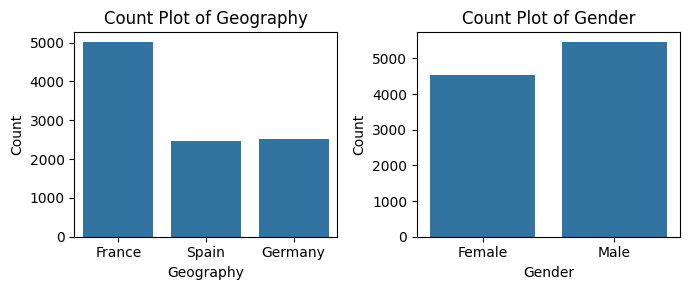

In [31]:
#Visual of categorical_feature

fig, axes = plt.subplots(1, 2, figsize=(7, 3))  

# Create count plots for each categorical feature
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [32]:
for feature in categorical_features:
    print(f"Feature: {feature}")
    print(pd.DataFrame(df[feature].value_counts()))  
    print("-" * 20)  

Feature: Geography
           count
Geography       
France      5014
Germany     2509
Spain       2477
--------------------
Feature: Gender
        count
Gender       
Male     5457
Female   4543
--------------------


1. France is the most frequent category, with 5014 customers, representing over half of the dataset. this imbalance data might be a consideration if we are building a predictive model
2. While not perfectly balanced, the gender distribution is not as skewed as the geography distribution

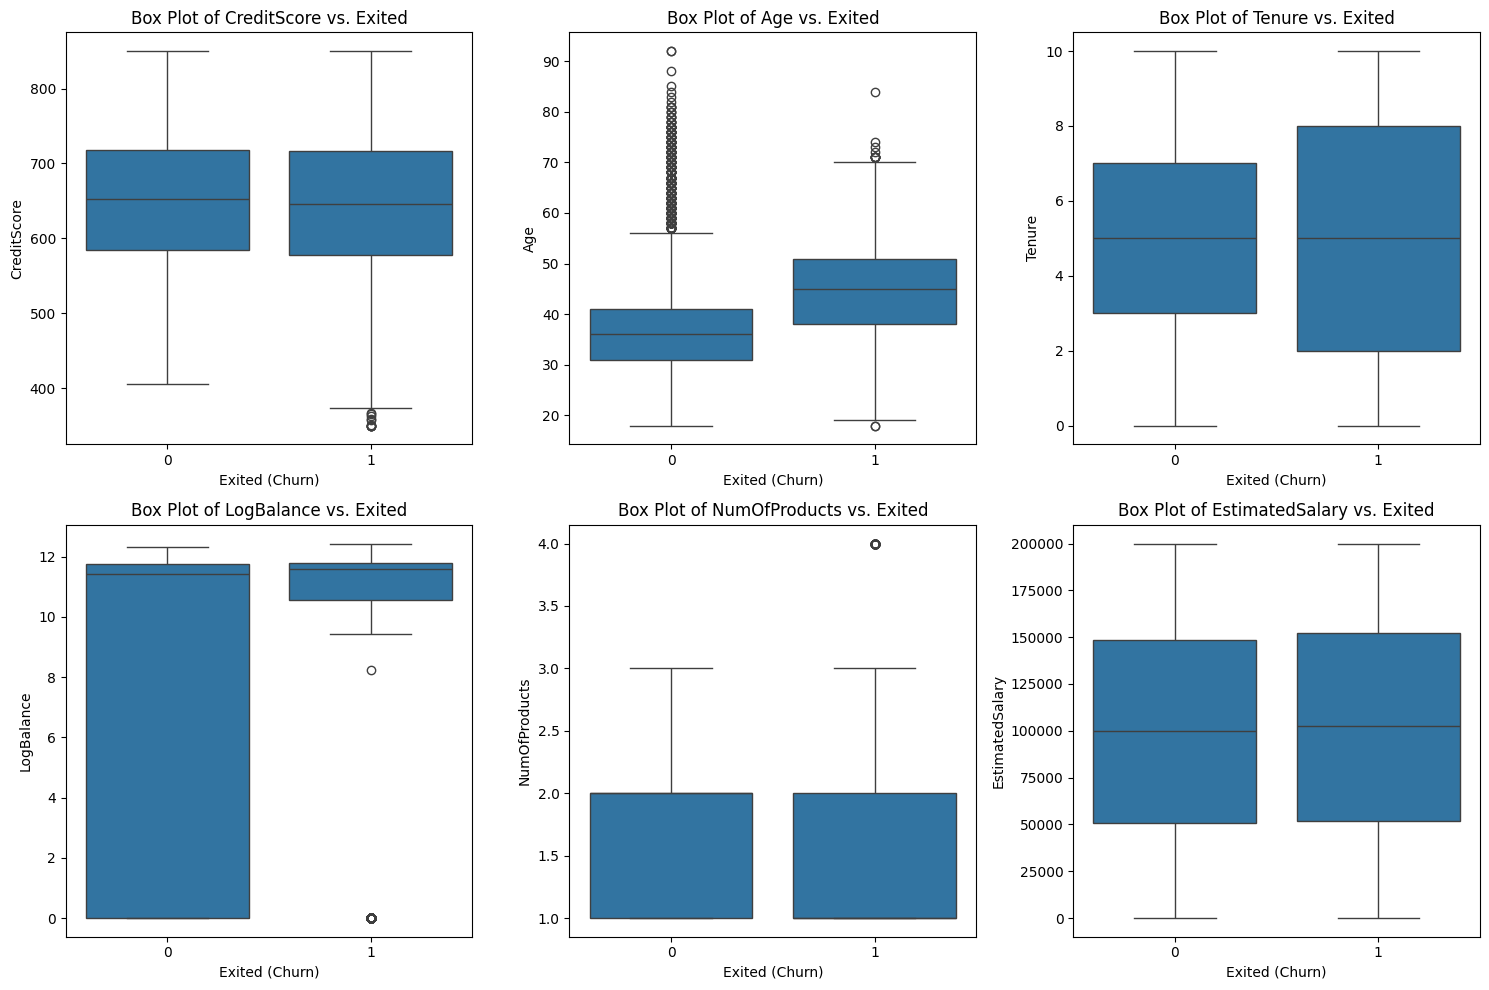

In [36]:
#Numerical_features vs excited 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows to fit all 6 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, column in enumerate(numerical_features):
    sns.boxplot(x='Exited', y=column, data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of {column} vs. Exited')
    axes[i].set_xlabel('Exited (Churn)')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

1. CreditScore: The median credit score for churned customers is slightly lower than for non-churned customers. Customers with lower credit scores might be slightly more likely to churn. This could indicate financial instability or dissatisfaction leading to churn.
2. Age: The median age for churned customers is noticeably higher than for non-churned customers. Older customers are more likely to churn. This is a valuable insight. It could be due to various reasons like retirement, changing life priorities, or perhaps the service is not catering well to older demographics.
3. Tenure: The median tenure for churned customers is lower than for non-churned customers. Customers who have been with the service for a shorter period are more likely to churn. This is a common finding – new customers are often more sensitive to issues and might switch services more readily.
4. LogBalance: The median log balance for churned customers is slightly lower than for non-churned customers. While the difference is not huge, it suggests that customers with lower balances (after log transformation, which accounts for the skew) might be slightly more likely to churn. This could be because they use the service less or find less value in it.
5. NumOfProducts: Customers with fewer products are more likely to churn. This is intuitive – customers who are more engaged with the service by using more products are less likely to leave.
6. EstimatedSalary: The distributions of estimated salaries for churned and non-churned customers are very similar.

I need to do t-test.


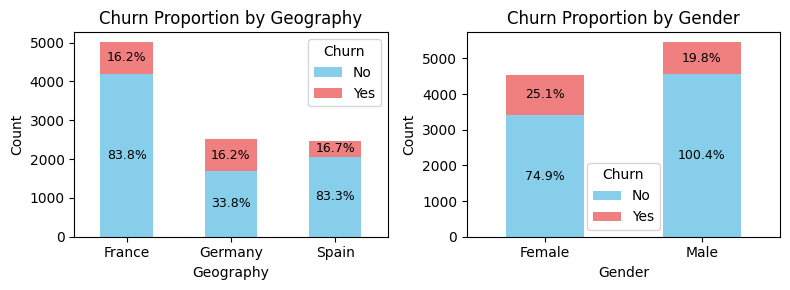

In [40]:
#Categorical_features vs Excited as a target
fig, axes = plt.subplots(1, len(categorical_features), figsize=(8, 3))

# Flatten axes if there's only one subplot
if len(categorical_features) == 1:
    axes = [axes]  

for i, feature in enumerate(categorical_features):
    ax = axes[i]

    # Calculate churn proportions for each category
    churn_counts = df.groupby([feature, 'Exited']).size().unstack(fill_value=0)
    churn_proportions = churn_counts.apply(lambda x: x / x.sum() * 100, axis=1)

    # Plot stacked bar chart
    churn_counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'lightcoral']) 

    # Add percentage labels
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = (height / churn_counts.loc[df[feature].unique()[int(x)]].sum()) * 100 
        ax.annotate(f'{percentage:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=9, color='black')

    ax.set_title(f'Churn Proportion by {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Churn', labels=['No', 'Yes'])  

    # Rotate x-axis labels 
    ax.tick_params(axis='x', rotation=0) 

plt.tight_layout()
plt.show()

In [42]:
#T-Test
from scipy.stats import ttest_ind, mannwhitneyu

# Loop through numerical columns and perform appropriate test
for col in numerical_features:
    print(f"\n--- {col} ---")
    group0 = df[df['Exited'] == 0][col]  # Non-churned group
    group1 = df[df['Exited'] == 1][col]  # Churned group

    # Check for normality (using Shapiro-Wilk test as an example - you can use others)
    from scipy.stats import shapiro
    stat, p = shapiro(group0)
    alpha = 0.05
    if p > alpha:
        normality_group0 = True # data looks normal
    else:
        normality_group0 = False # data is not normal
        
    stat, p = shapiro(group1)
    if p > alpha:
        normality_group1 = True # data looks normal
    else:
        normality_group1 = False # data is not normal
    
    normal = normality_group0 and normality_group1

    if normal:  # If both groups are approximately normal
        print("Performing t-test...")
        t_stat, p_value = ttest_ind(group0, group1)
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_value:.3f}")

    else:  # If either group is not normally distributed
        print("Performing Mann-Whitney U test...")
        u_stat, p_value = mannwhitneyu(group0, group1)
        print(f"U-statistic: {u_stat:.3f}")
        print(f"P-value: {p_value:.3f}")

    alpha = 0.05  # Significance level
    if p_value < alpha:
        print(f"Difference in {col} between churned and non-churned groups is statistically significant.")
    else:
        print(f"Difference in {col} between churned and non-churned groups is NOT statistically significant.")



--- CreditScore ---
Performing Mann-Whitney U test...
U-statistic: 8381083.000
P-value: 0.020
Difference in CreditScore between churned and non-churned groups is statistically significant.

--- Age ---
Performing Mann-Whitney U test...
U-statistic: 4345981.500
P-value: 0.000
Difference in Age between churned and non-churned groups is statistically significant.

--- Tenure ---
Performing Mann-Whitney U test...
U-statistic: 8272055.500
P-value: 0.162
Difference in Tenure between churned and non-churned groups is NOT statistically significant.

--- LogBalance ---
Performing Mann-Whitney U test...
U-statistic: 6849444.500
P-value: 0.000
Difference in LogBalance between churned and non-churned groups is statistically significant.

--- NumOfProducts ---
Performing Mann-Whitney U test...
U-statistic: 9390005.500
P-value: 0.000
Difference in NumOfProducts between churned and non-churned groups is statistically significant.

--- EstimatedSalary ---
Performing Mann-Whitney U test...
U-statistic

c:\Users\Dwi Fitria\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7963.
  res = hypotest_fun_out(*samples, **kwds)


Predictive Features: CreditScore, Age, LogBalance, and NumOfProducts are likely to be useful predictors of churn, as their distributions differ significantly between churned and non-churned customers.

In [43]:
# For categorical features (e.g., Geography, Gender), use Chi-Square test
from scipy.stats import chi2_contingency

for col in categorical_features:
    print(f"\n--- {col} ---")
    contingency_table = pd.crosstab(df[col], df['Exited'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square statistic: {chi2:.3f}")
    print(f"P-value: {p:.3f}")

    alpha = 0.05
    if p < alpha:
        print(f"Association between {col} and churn is statistically significant.")
    else:
        print(f"Association between {col} and churn is NOT statistically significant.")


--- Geography ---
Chi-square statistic: 301.255
P-value: 0.000
Association between Geography and churn is statistically significant.

--- Gender ---
Chi-square statistic: 112.919
P-value: 0.000
Association between Gender and churn is statistically significant.


Both Geography and Gender appear to be important factors in customer churn

In [44]:
# 4. Define Features (X) and Target (y)
X = df.drop('Exited', axis=1)  # Features (all columns except 'Exited')
y = df['Exited']  # Target variable (churn)

# 5. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

In [61]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
# Preprocessing and Feature Engineering Pipeline

# Define numerical and categorical features 
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# preprocessing steps
numeric_pipeline = ColumnTransformer([
   ('scaler', StandardScaler(), numerical_features)
])

categorical_pipeline = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Feature Selection 
feature_selector = SelectKBest(f_classif, k=15)

# Combine preprocessing steps with ColumnTransformer 
preprocessor = ColumnTransformer(  
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Apply Transformations to Train Set (Fit and Transform)
X_train_processed = preprocessor.fit_transform(X_train)
X_train_selected = feature_selector.fit_transform(X_train_processed, y_train)

# Apply SAME Transformations to Test Set 
X_test_processed = preprocessor.transform(X_test)
X_test_selected = feature_selector.transform(X_test_processed)


c:\Users\Dwi Fitria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=14. All the features will be returned.
  warnings.warn(


In [57]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 


# Define models and hyperparameter grids
models = {
    "Logistic Regression": (
        LogisticRegression(solver='liblinear', random_state=42),  
        {
            'C': [0.01, 0.1, 1, 10, 100],  
            'penalty': ['l1', 'l2']  
        }
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
            'min_samples_leaf': [1, 2, 4]  # Minimum samples in a leaf node
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 
        {
            'n_estimators': [50, 100, 200],  # Number of boosting rounds
            'learning_rate': [0.01, 0.1, 0.5],  # Learning rate
            'max_depth': [3, 5, 7]  # Maximum depth of the tree
        }
    )
}

In [ ]:
results = {}  # Initialize the results dictionary

for model_name, model, param_grid in models: # models is list of tuples (model_name, model, param_grid)
    print(f"--- {model_name} ---")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)
    grid_search.fit(X_train_processed, y_train)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    results[model_name] = {'best_score': best_score, 'best_params': best_params} # Add results here!

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

In [67]:
# Perform cross-validation and grid search for each model
results = {}
for model_name, (model, param_grid) in models.items():
    print(f"--- {model_name} ---")

    # Use StratifiedKFold for classification to handle class imbalance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1) 
    grid_search.fit(X_train_processed, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    results[model_name] = {"best_model": best_model,"best_params": best_params,"best_score": best_score}
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

--- Logistic Regression ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation score: 0.8139
--- Decision Tree ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.8530
--- XGBoost ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Dwi Fitria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Dwi Fitria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Dwi Fitria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.8633


XGBoost is the top performer based on cross-validation scores (0.8633), followed by the Decision Tree (0.8530) and then Logistic Regression (0.8139).  This is a common outcome; ensemble methods like XGBoost often outperform simpler models.

In [68]:
# Evaluate the best models on the test set
print("\n--- Test Set Evaluation ---")
for model_name, result in results.items():
    best_model = result["best_model"]
    test_score = best_model.score(X_test_selected, y_test)  
    print(f"{model_name}: Test score = {test_score:.4f}")

# Print the model and parameters of the best performing model
best_performing_model = max(results, key=lambda k: results[k]['best_score'])
print(f"\nBest performing model: {best_performing_model}")
print(f"Best parameters: {results[best_performing_model]['best_params']}")


--- Test Set Evaluation ---
Logistic Regression: Test score = 0.8105
Decision Tree: Test score = 0.8575
XGBoost: Test score = 0.8700

Best performing model: XGBoost
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA  

# Define numerical and categorical features (AFTER dropping irrelevant columns)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(exclude=np.number).columns.tolist()

# Drop irrelevant columns (RowNumber, CustomerId, Surname, Exited)
df = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)

# 3. Preprocessing (ADAPTED)
numeric_pipeline = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_features)
])

categorical_pipeline = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

X_processed = preprocessor.fit_transform(df)  

# 4. Dimensionality Reduction (Optional)
pca = PCA(n_components=10)  
X = pca.fit_transform(X_processed)  

# X is now your feature matrix ready for clustering
print(X.shape)

# Example: Convert to DataFrame for easier handling (optional)
X_df = pd.DataFrame(X)  

# Now apply your clustering algorithm (e.g., K-Means)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)  
df['Cluster'] = kmeans.fit_predict(X)  #

# Analyze clusters (use the 'Exited' column if you want to see churn distribution in clusters)
print(df.groupby('Cluster')['Exited'].value_counts(normalize=True))

(10000, 10)
Cluster  Exited
0        0         0.831653
         1         0.168347
1        0         0.852570
         1         0.147430
2        0         0.684312
         1         0.315688
3        0         0.810207
         1         0.189793
4        0         0.912202
         1         0.087798
Name: proportion, dtype: float64


(10000, 10): This likely refers to the shape of your data after clustering. It means you have 10,000 customers and 10 features (including the newly assigned cluster label).
Cluster: This column represents the cluster number (0, 1, 2, 3, 4 in your case). Customers have been grouped into these clusters based on their features.
Exited: This column indicates whether a customer exited (1) or not (0).
Proportion: This column shows the proportion of customers within each cluster who exited or did not exit.

Cluster 2 has the highest churn rate. This cluster is a key area of focus for churn reduction efforts. We should investigate the characteristics of customers in this cluster to understand why they are more likely to churn.
Cluster 4 has the lowest churn rate. Understanding the characteristics of customers in this cluster can provide insights into what factors contribute to customer retention.
Clusters 0, 1, and 3 have moderate churn rates. These clusters also warrant attention, though perhaps less urgent than cluster 2.

       CreditScore          Age       Tenure        Balance  NumOfProducts  \
count  3098.000000  3098.000000  3098.000000    3098.000000    3098.000000   
mean    647.929309    38.516785     5.108134  120654.390872       1.387024   
std      98.604587     9.167047     2.890241   29559.172364       0.590791   
min     350.000000    18.000000     0.000000   12459.190000       1.000000   
25%     580.000000    32.000000     3.000000  100994.485000       1.000000   
50%     650.000000    38.000000     5.000000  120213.625000       1.000000   
75%     716.000000    44.000000     8.000000  139707.037500       2.000000   
max     850.000000    84.000000    10.000000  222267.630000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary       Exited   LogBalance  \
count  3098.000000          3098.0      3098.000000  3098.000000  3098.000000   
mean      0.708199             0.0    101514.362053     0.315688    11.667339   
std       0.454665             0.0     57524.806190   

C:\Users\Dwi Fitria\AppData\Local\Temp\ipykernel_15608\2229101779.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cluster_2_customers['Age'], df['Age']], labels=['Cluster 2', 'Overall'])


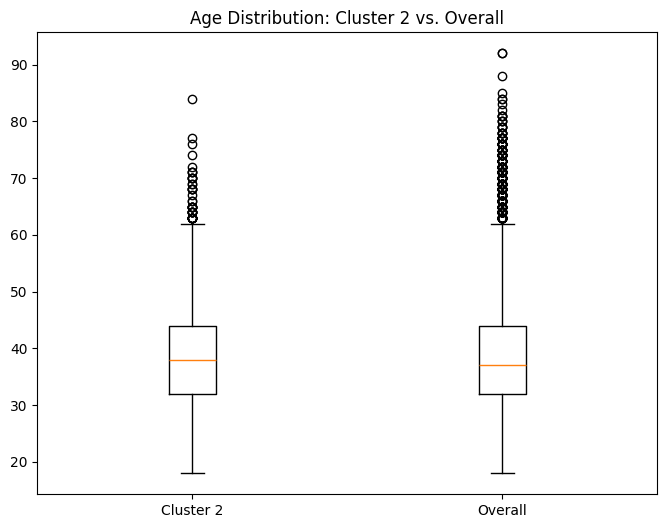

In [74]:
#Analyzing cluster 2
cluster_2_customers = df[df['Cluster'] == 2]

# Analyze numerical features
print(cluster_2_customers.describe())

# Analyze categorical features
print(cluster_2_customers['Geography'].value_counts())
print(cluster_2_customers['Gender'].value_counts())

# Visualize (example)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.boxplot([cluster_2_customers['Age'], df['Age']], labels=['Cluster 2', 'Overall'])
plt.title('Age Distribution: Cluster 2 vs. Overall')
plt.show()


Characteristic cluster 2
1. Age: The average age in Cluster 2 is around 38.5 years, with a standard deviation of 9.17. The age range goes from 18 to 84.
2. Credit Score: The average credit score is about 648.
3. Tenure: The average tenure is approximately 5.1 years.
4. Balance: The average balance is quite high, around 120,654.
5. NumOfProducts: Most customers in this cluster have 1 or 2 products.
6. Estimated Salary: The average estimated salary is around 101,514.
7. HasCrCard: About 70% of customers in Cluster 2 have a credit card.
8. IsActiveMember: All customers in this specific slice of Cluster 2 are not active members (IsActiveMember = 0). This is a very important finding.
9. Geography: The distribution of geography is fairly even between France and Germany, with fewer customers from Spain.
10. Gender: There are slightly more male customers in this cluster than female customers.

In [73]:
# Add Cluster Labels to the DataFrame
cluster_labels = kmeans.fit_predict(X)
df['Cluster'] = cluster_labels  

# Now 'df' has the new 'Cluster' column
print(df.head())  
print(df['Cluster'].value_counts()) 

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  LogBalance  Cluster  
0          1               1        101348.88       1    0.000000        4  
1          0               1        112542.58       0   11.336294        0  
2          1               0        113931.57       1   11.980813        2  
3          0               0         93826.63       0    0.000000        1  
4          1               1         79084.10       0   11.740155        0  
Cluster
0    3273
2    3098
4    1344
3    1254
1    1031
Name: count, dtype: int64


There is 3098 person in total for cluster 2.